<a href="https://colab.research.google.com/github/pieter98/IRT/blob/main/GIRTH_IRT_implementation_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0) Setup notebook

The following code is some coding magic to setup the notebook with python 3.8 (which is not by default supported in google colab). Google colab notebooks use python 3.7 by default, however the girth library requires python 3.8 or higher.

In [ ]:
!wget -O mini.sh https://repo.anaconda.com/miniconda/Miniconda3-py38_4.8.2-Linux-x86_64.sh
!chmod +x mini.sh
!bash ./mini.sh -b -f -p /usr/local
!conda install -q -y jupyter
!conda install -q -y google-colab -c conda-forge
!python -m ipykernel install --name "py38" --user

--2022-11-14 17:37:26--  https://repo.anaconda.com/miniconda/Miniconda3-py38_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89817099 (86M) [application/x-sh]
Saving to: ‘mini.sh’

mini.sh             100%[===================>]  85.66M  97.3MB/s    in 0.9s    

2022-11-14 17:37:27 (97.3 MB/s) - ‘mini.sh’ saved [89817099/89817099]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py38_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py38_0
    - cffi==1.14.0=py38h2e261b9_0
    - chardet==3.0.4=py38_1003
    - conda-package-handling==1.6.0=py38h7b6447c_0
    - conda==4.8.2=py38_0
    - crypt

Reload the web page and execute the next cell

In [1]:
# Reload the web page and execute this cell
import sys
print("User Current Version:-", sys.version)

User Current Version:- 3.8.13 (default, Oct 21 2022, 23:50:54) 
[GCC 11.2.0]


In [2]:
!python --version

Python 3.8.13


In [3]:
!pip install girth

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67 kB 2.4 MB/s 
     |████████████████████████████████| 33.8 MB 375 kB/s 


# 1) Parse data from the datafile and transform it to the right format


---


The girth library expects input data of the following format:
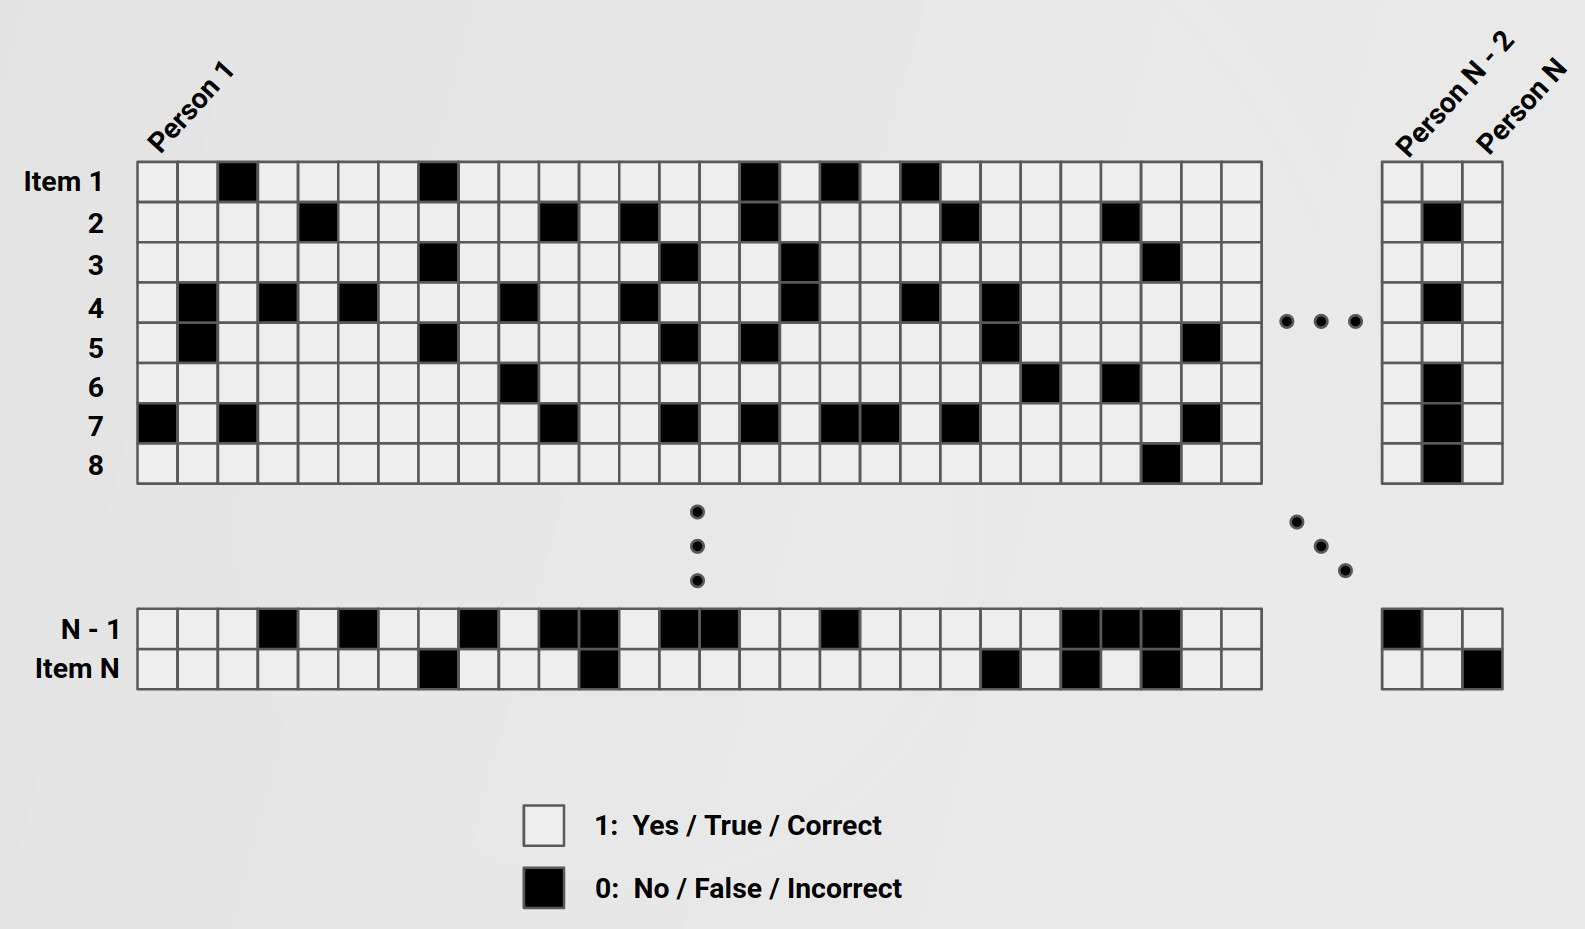

This part of the code will deal with transforming our data to this requested format. The current data consists of a large csv file where each line of the csv represents the answer of a specific user for a specific question for a specific publication (exam/test).

## 1.1 data parsing method
we define a method to parse the data for our specific use case:

In [5]:
import numpy as np
import pandas as pd

In [6]:
def transform_data_for_specific_publication_id(publication_id, resource_file_path):
    df = pd.read_csv(resource_file_path, delimiter=";")
    df_publication = df[(df['PublicationId'] == publication_id)]
    unique_questions = df_publication['QuestionId'].unique()
    result_array = []
    for question in unique_questions:
        df_temp = df_publication[df_publication['QuestionId'] == question].sort_values(['UserId'])
        question_array = []
        count1 = 0
        count0 = 0
        for data in df_temp.iterrows():
            if data[1]['UserPassed'] == 0:
                count0 += 1
            else:
                count1 += 1
            question_array.append(int(data[1]['UserPassed']))
        result_array.append(question_array)
    return np.array(result_array)

## 1.2 test of data parsing method
Let's test the functionality of the method by exporting the data for one specific publication (e.g. publication with id 1).

In [ ]:
test_data = transform_data_for_specific_publication_id(1, '/content/sample_data/IRT-dataset_2_GPT3-topic-extractions.csv')
print(test_data)
print(f'\nshape: {test_data.shape}')

[[1 1 1 ... 1 1 1]
 [0 0 1 ... 1 1 0]
 [0 1 1 ... 0 1 0]
 [1 1 1 ... 1 1 0]
 [1 0 1 ... 1 1 1]
 [1 0 1 ... 0 1 0]]

shape: (6, 501)


As result we get a dataset of 6 questions with each 501 answers. 

## 1.3 getting the data for a specific publication


In [13]:
publication_id = 164
publication_data = transform_data_for_specific_publication_id(publication_id, '/content/sample_data/IRT-dataset_2_GPT3-topic-extractions.csv')
print(publication_data)
publication_data.shape

[[1 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 0 1 0]
 ...
 [0 1 1 ... 1 1 1]
 [0 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 0]]


(8, 677)

# 2) 1-parameter logistic model (1PL)
Let's use the girth package to calibrate the item difficulties using a 1PL model.
## 2.1 GIRTH 1PL

In [7]:
from girth import standard_errors_bootstrap, onepl_mml

In [ ]:
results_onepl = standard_errors_bootstrap(publication_data, onepl_mml, n_processors=1, bootstrap_iterations=1000)

In [ ]:
results_onepl

{'Solution': {'Discrimination': 1.0392510760413345,
  'Difficulty': array([-3.7322051 , -0.69610094, -0.37520832, -2.06430867, -2.1459991 ,
         -0.75661882, -3.6412254 , -2.5968761 ])},
 '95th CI': {'Discrimination': [array([0.91289832]), array([1.17822065])],
  'Difficulty': [array([-4.42782035, -0.8881055 , -0.55838968, -2.41278677, -2.47022056,
          -0.94958626, -4.25072804, -2.99719196]),
   array([-3.24392891, -0.5210237 , -0.20612652, -1.77054069, -1.86116699,
          -0.56023199, -3.15129592, -2.25019022])]},
 'Standard Errors': {'Discrimination': array([0.06841366]),
  'Difficulty': array([0.29420668, 0.09554111, 0.09215748, 0.16464185, 0.15613419,
         0.09898782, 0.29551888, 0.19297909])},
 'Bias': {'Discrimination': array([0.00246146]),
  'Difficulty': array([-3.78053489e-02, -4.54599290e-03, -9.51784770e-05, -8.88215512e-03,
         -8.99491703e-03,  2.36917943e-03, -3.03739898e-02, -9.18149791e-03])}}

## 2.2 Item Characteristic Curves visualization (ICC):

For visualization we use the matplotlib to plot our results.

ICC is plot of the probability that a test item is answered correctly against the examinee’s underlying ability on the trait being measured.

In [20]:
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.4 MB 5.2 MB/s 
     |████████████████████████████████| 3.2 MB 37.4 MB/s 
     |████████████████████████████████| 295 kB 42.4 MB/s 
     |████████████████████████████████| 965 kB 52.9 MB/s 
     |████████████████████████████████| 1.2 MB 63.4 MB/s 


### 2.2.1 Defining a helper *method*

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import math

In [ ]:
def onepl_calculation_icc(b, test_range):
  values = []
  for point in test_range:
    numerator = math.exp(point - b)
    denominator = 1 + math.exp(point - b)
    result = numerator / denominator
    values.append(result)
  return values

We create an interval array  [ -10:0.01:10] which we will use to calculate the ICC function values for each of the questions in our publication.

In [ ]:
one_PL_difficulties = results_onepl['Solution']['Difficulty']
y_values = []
test_range = np.arange(-10.0, 10.0, 0.01)
for difficulty in one_PL_difficulties:
  y_values.append(onepl_calculation_icc(difficulty, test_range))

Plot the ICCs for each question

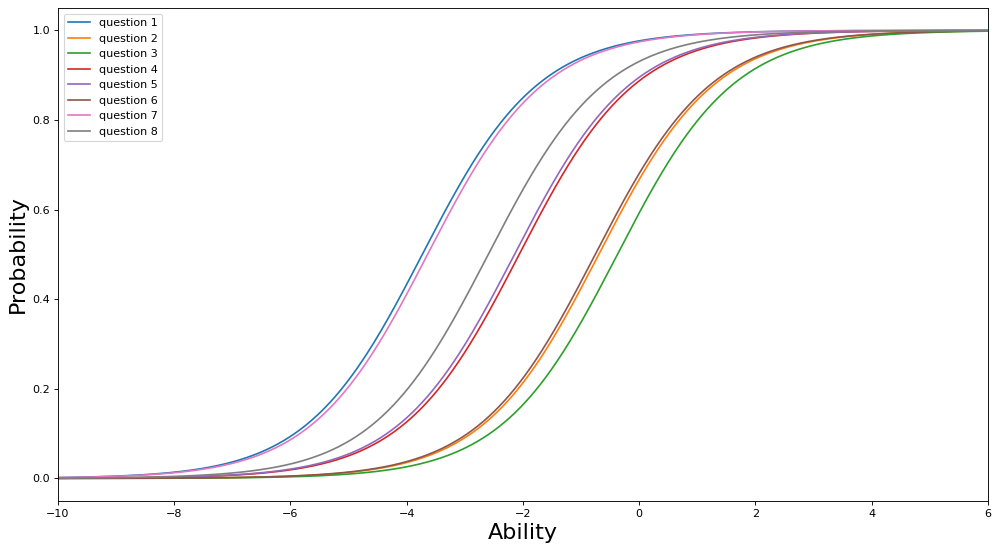

In [ ]:
plt.figure(figsize=(15,8), dpi=80)
plt.xlim(right=6)
plt.xlim(left=-10)
for i, y_value in enumerate(y_values):
  plt.plot(test_range, y_value, label=f'question {i+1}')

plt.xlabel("Ability", fontsize="20")
plt.ylabel("Probability", fontsize="20")
plt.legend()
plt.show()

## 2.3 Item Information Curves visualization (ICC):

Item information curves show how much “information” about the latent trait ability an item gives. Mathematically, these are the 1st derivatives of the ICCs. Item information curves peak at the difficulty value (point where the item has the highest discrimination), with less information at ability levels farther from the difficulty estimate.

In [ ]:
def onepl_calculation_iic(b, test_range):
  values = []
  for point in test_range:
    numerator = math.exp(point + b)
    denominator = math.pow(math.exp(point) + math.exp(b), 2)
    result = numerator / denominator
    values.append(result)
  return values

In [ ]:
one_PL_difficulties = results_onepl['Solution']['Difficulty']
y_values_iic = []
test_range = np.arange(-10.0, 10.0, 0.01)
for difficulty in one_PL_difficulties:
  y_values_iic.append(onepl_calculation_iic(difficulty, test_range))

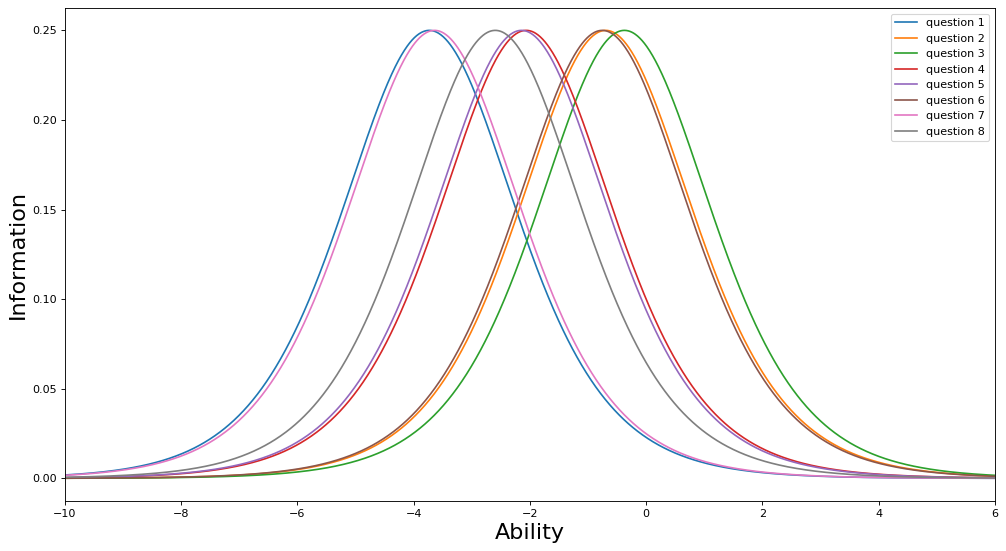

In [ ]:
plt.figure(figsize=(15,8), dpi=80)
plt.xlim(right=6)
plt.xlim(left=-10)
for i, y_value in enumerate(y_values_iic):
  plt.plot(test_range, y_value, label=f'question {i+1}')

plt.xlabel("Ability", fontsize="20")
plt.ylabel("Information", fontsize="20")
plt.legend()
plt.show()

## 2.4 95th confidence interval:

In [ ]:
difficulties_ordered_low_high = one_PL_difficulties.copy()
difficulties_ordered_low_high.sort()
difficulties_ordered_low_high

dict = {}
for i, value in enumerate(difficulties_ordered_low_high):
  dict[value] = []
  dict[value].append(i)
dict

{-3.732205104600317: [0],
 -3.6412254003385423: [1],
 -2.5968761039516295: [2],
 -2.145999096667259: [3],
 -2.064308671746109: [4],
 -0.756618820737348: [5],
 -0.6961009388987104: [6],
 -0.3752083165159407: [7]}

In [ ]:
standard_errors = results_onepl['95th CI']['Difficulty']
standard_errors

[array([-4.42782035, -0.8881055 , -0.55838968, -2.41278677, -2.47022056,
        -0.94958626, -4.25072804, -2.99719196]),
 array([-3.24392891, -0.5210237 , -0.20612652, -1.77054069, -1.86116699,
        -0.56023199, -3.15129592, -2.25019022])]

In [ ]:
one_PL_difficulties

array([-3.7322051 , -0.69610094, -0.37520832, -2.06430867, -2.1459991 ,
       -0.75661882, -3.6412254 , -2.5968761 ])

In [ ]:
results_onepl['Solution']['Difficulty']

array([-3.7322051 , -0.69610094, -0.37520832, -2.06430867, -2.1459991 ,
       -0.75661882, -3.6412254 , -2.5968761 ])

In [ ]:
for i, value in enumerate(one_PL_difficulties):
  # add lower interval bound
  dict[value].append(standard_errors[0][i])
  dict[value].append(standard_errors[1][i])

In [ ]:
dict

{-3.732205104600317: [0, -4.427820348474748, -3.2439289063452743],
 -3.6412254003385423: [1, -4.250728036180455, -3.151295918088983],
 -2.5968761039516295: [2, -2.997191960612111, -2.2501902168070855],
 -2.145999096667259: [3, -2.4702205592188418, -1.861166986792515],
 -2.064308671746109: [4, -2.4127867712899818, -1.7705406949744413],
 -0.756618820737348: [5, -0.9495862574726769, -0.5602319866104686],
 -0.6961009388987104: [6, -0.8881055002509405, -0.5210237033116486],
 -0.3752083165159407: [7, -0.5583896793206419, -0.20612651813524974]}

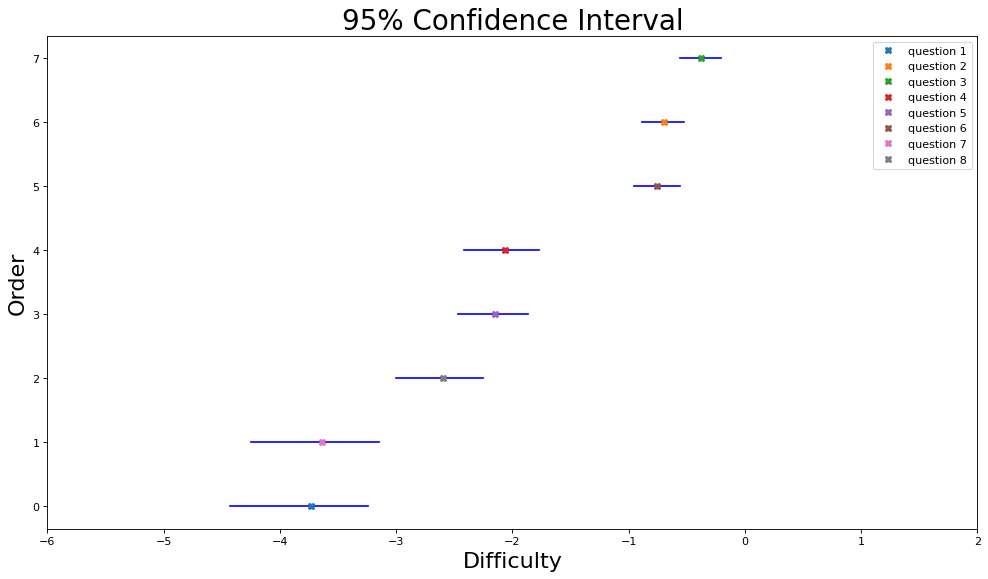

In [ ]:
plt.figure(figsize=(15,8), dpi=80)
plt.xlim(right=2)
plt.xlim(left=-6)
for i, value in enumerate(one_PL_difficulties):
  plt.plot([dict[value][1], dict[value][2]], [dict[value][0], dict[value][0]], 'b')
  plt.plot([value], [dict[value][0]], 'X', label=f'question {i+1}')

plt.xlabel("Difficulty", fontsize="20")
plt.ylabel("Order", fontsize="20")
plt.title("95% Confidence Interval", fontsize="25")
plt.legend()
plt.show()

# 3) 2-parameter logistic model (2PL)
Let's use the girth package to calibrate the item difficulties using a 2PL model.
## 3.1 GIRTH 2PL

In [4]:
from girth import twopl_mml

In [14]:
results_twopl = standard_errors_bootstrap(publication_data, twopl_mml, n_processors=1, bootstrap_iterations=1000)

In [15]:
results_twopl

{'Solution': {'Discrimination': array([0.6484035 , 1.95577778, 0.34371424, 1.18008125, 1.10320102,
         1.428865  , 1.29066512, 0.96707587]),
  'Difficulty': array([-5.53309119, -0.49129097, -0.95406724, -1.89238587, -2.05812394,
         -0.62096326, -3.11931329, -2.73873285]),
  'Ability': array([-1.68168596,  0.79537794,  0.79537794,  0.4469406 ,  0.60466727,
          0.79537794,  0.79537794,  0.79537794, -2.04892722,  0.79537794,
         -0.06205183,  0.79537794, -0.79617627, -1.13786584, -0.27218686,
          0.79537794, -0.06205183,  0.79537794,  0.79537794, -0.67374071,
          0.79537794, -0.51743209, -0.3610874 , -1.56223145, -0.67374071,
          0.79537794, -0.1366753 , -0.51743209, -0.27218686,  0.08335262,
          0.60466727,  0.79537794,  0.79537794,  0.08335262,  0.79537794,
          0.79537794, -0.79617627,  0.79537794, -0.27218686,  0.60466727,
          0.60466727,  0.60466727,  0.60466727,  0.79537794, -0.58414333,
         -0.62409484, -1.21345604, -0.2

## 3.2 Item Characteristic Curves visualization (ICC):

For visualization we use the matplotlib to plot our results.

ICC is plot of the probability that a test item is answered correctly against the examinee’s underlying ability on the trait being measured.

In [17]:
def twopl_calculation_icc(a, b, test_range):
  values = []
  for point in test_range:
    numerator = math.exp(a*(point - b))
    denominator = 1 + math.exp(a*(point - b))
    result = numerator / denominator
    values.append(result)
  return values

We create an interval array  [ -10:0.01:10] which we will use to calculate the ICC function values for each of the questions in our publication.

In [22]:
difficulties_twopl = results_twopl['Solution']['Difficulty']
discriminations_twopl = results_twopl['Solution']['Discrimination']
y_values_icc = []
test_range = np.arange(-15.0, 15.0, 0.01)
for i, difficulty in enumerate(difficulties_twopl):
  y_values_icc.append(twopl_calculation_icc(discriminations_twopl[i], difficulty, test_range))

Plot the ICCs for each question

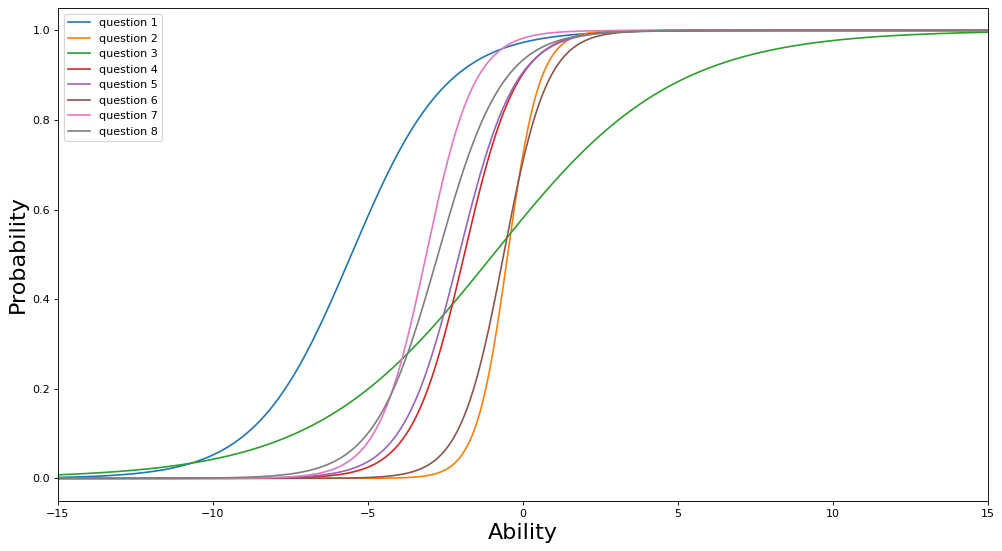

In [23]:
plt.figure(figsize=(15,8), dpi=80)
plt.xlim(right=15)
plt.xlim(left=-15)
for i, y_value in enumerate(y_values_icc):
  plt.plot(test_range, y_value, label=f'question {i+1}')

plt.xlabel("Ability", fontsize="20")
plt.ylabel("Probability", fontsize="20")
plt.legend()
plt.show()

## 3.3 Item Information Curves visualization (ICC):

Item information curves show how much “information” about the latent trait ability an item gives. Mathematically, these are the 1st derivatives of the ICCs. Item information curves peak at the difficulty value (point where the item has the highest discrimination), with less information at ability levels farther from the difficulty estimate.

In [38]:
def twopl_calculation_iic(a, b, test_range):
  values = []
  for point in test_range:
    #numerator = a * math.exp(a*(point - b))
    #denominator = math.pow(math.exp(a*(point-b)) + 1, 2)
    #result = numerator / denominator
    #values.append(result)
    temp1 = math.exp(a * (point - b))
    temp2 = a * temp1
    temp3 = math.pow((temp1 + 1), 2)
    values.append(temp2 / temp3)
  return values

In [44]:
y_values_iic_twopl = []
test_range = np.arange(-10.0, 10.0, 0.01)
for i, difficulty in enumerate(difficulties_twopl):
  y_values_iic_twopl.append(twopl_calculation_iic(discriminations_twopl[i], difficulties_twopl[i], test_range))
# y_values_iic

[[0.012528531997660186,
  0.012647053239518426,
  0.012766664475689748,
  0.012887375128857492,
  0.013009194691481263,
  0.013132132726079366,
  0.013256198865507052,
  0.013381402813230544,
  0.013507754343596556,
  0.013635263302097215,
  0.013763939605630264,
  0.013893793242754271,
  0.01402483427393882,
  0.014157072831809342,
  0.014290519121386597,
  0.01442518342032051,
  0.014561076079118196,
  0.014698207521365999,
  0.014836588243945422,
  0.014976228817242651,
  0.015117139885351523,
  0.015259332166269788,
  0.015402816452088429,
  0.015547603609173729,
  0.015693704578342127,
  0.015841130375027393,
  0.015989892089440037,
  0.016140000886718707,
  0.016291468007073415,
  0.01644430476592016,
  0.016598522554007056,
  0.016754132837531324,
  0.016911147158247257,
  0.017069577133564735,
  0.017229434456638056,
  0.01739073089644484,
  0.017553478297854867,
  0.017717688581688314,
  0.017883373744763485,
  0.018050545859933376,
  0.01821921707611118,
  0.01838939961828415

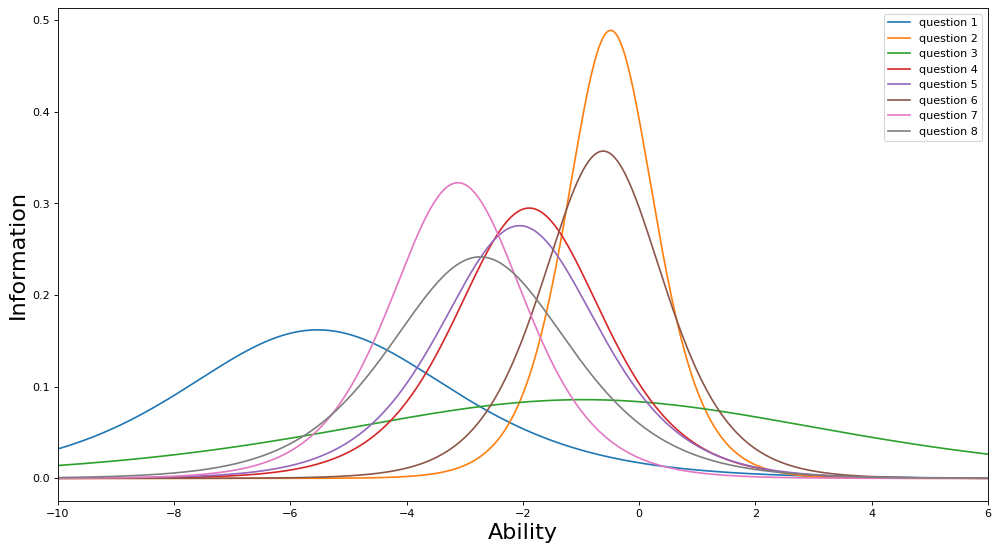

In [45]:
plt.figure(figsize=(15,8), dpi=80)
plt.xlim(right=6)
plt.xlim(left=-10)
for i, y_value in enumerate(y_values_iic_twopl):
  plt.plot(test_range, y_value, label=f'question {i+1}')

plt.xlabel("Ability", fontsize="20")
plt.ylabel("Information", fontsize="20")
plt.legend()
plt.show()

# 4) 3-parameter logistic model (3PL)
Let's use the girth package to calibrate the item difficulties using a 2PL model.
## 4.1 GIRTH 3PL

In [46]:
from girth import threepl_mml

In [47]:
results_threepl = standard_errors_bootstrap(publication_data, threepl_mml, n_processors=1, bootstrap_iterations=1000)

In [48]:
results_threepl

{'Solution': {'Discrimination': array([0.8148751 , 4.        , 0.34301725, 1.31929486, 1.56445939,
         3.50775208, 1.50733179, 1.4492982 ]),
  'Difficulty': array([-4.53683351, -0.00837058, -0.95574715, -1.30649259, -1.25786657,
          0.03837883, -2.5098903 , -1.70549177]),
  'Guessing': array([2.50969200e-08, 2.83674857e-01, 4.31446941e-08, 3.29999987e-01,
         3.29999979e-01, 3.29999985e-01, 3.29999984e-01, 3.29999972e-01])},
 '95th CI': {'Discrimination': [array([0.47631764, 2.28906255, 0.25      , 0.82750076, 0.92879298,
          1.55744119, 0.79001355, 0.7982312 ]),
   array([1.84004733, 4.        , 0.82531974, 2.05691206, 2.48650665,
          4.        , 2.88049107, 2.46149429])],
  'Difficulty': [array([-5.9999657 , -0.40994136, -1.40081807, -2.11738108, -2.24417266,
          -0.51545277, -4.18990735, -2.90938389]),
   array([-2.49292475,  0.15250234,  2.09387811, -0.95184694, -0.98437452,
           0.16354124, -1.86815327, -1.28419762])]},
 'Standard Errors': {

## 4.2 Item Characteristic Curves visualization (ICC):

For visualization we use the matplotlib to plot our results.

ICC is plot of the probability that a test item is answered correctly against the examinee’s underlying ability on the trait being measured.

In [49]:
def threepl_calculation_icc(a, b, c, test_range):
  values = []
  for point in test_range:
    numerator = math.exp(a*(point - b))
    denominator = 1 + math.exp(a*(point - b))
    value_one = numerator / denominator
    value_two = (1 - c)*value_one
    result = c + value_two
    values.append(result)
  return values

We create an interval array  [ -10:0.01:10] which we will use to calculate the ICC function values for each of the questions in our publication.

In [50]:
difficulties_threepl = results_threepl['Solution']['Difficulty']
discriminations_threepl = results_threepl['Solution']['Discrimination']
guessing_threepl = results_threepl['Solution']['Guessing']
y_values_icc = []
test_range = np.arange(-15.0, 15.0, 0.01)
for i, difficulty in enumerate(difficulties_threepl):
  y_values_icc.append(threepl_calculation_icc(discriminations_threepl[i], difficulty, guessing_threepl[i], test_range))

Plot the ICCs for each question

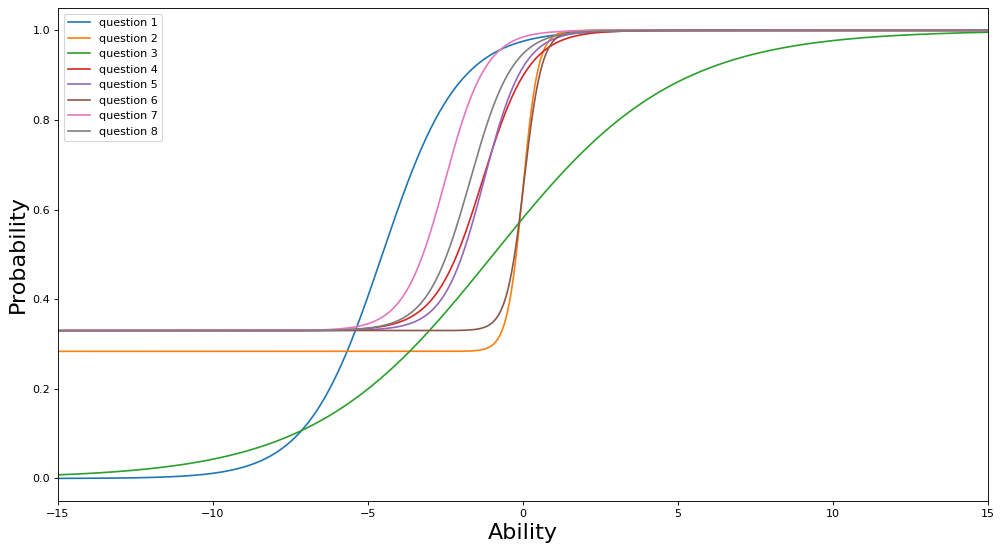

In [51]:
plt.figure(figsize=(15,8), dpi=80)
plt.xlim(right=15)
plt.xlim(left=-15)
for i, y_value in enumerate(y_values_icc):
  plt.plot(test_range, y_value, label=f'question {i+1}')

plt.xlabel("Ability", fontsize="20")
plt.ylabel("Probability", fontsize="20")
plt.legend()
plt.show()

## 4.3 Item Information Curves visualization (ICC):

Item information curves show how much “information” about the latent trait ability an item gives. Mathematically, these are the 1st derivatives of the ICCs. Item information curves peak at the difficulty value (point where the item has the highest discrimination), with less information at ability levels farther from the difficulty estimate.

In [57]:
def threepl_calculation_iic(a, b, c, test_range):
  values = []
  for point in test_range:
    temp1 = a * math.exp(a*(point - b))
    temp2 = (1 - c)
    numerator = temp1 * temp2
    denominator = math.pow(math.exp(a*(point-b)) + 1, 2)
    result = numerator / denominator
    values.append(result)
  return values

In [58]:
y_values_iic = []
test_range = np.arange(-10.0, 10.0, 0.01)
for i, difficulty in enumerate(difficulties_threepl):
  y_values_iic.append(threepl_calculation_iic(discriminations_threepl[i], difficulty, guessing_threepl[i], test_range))

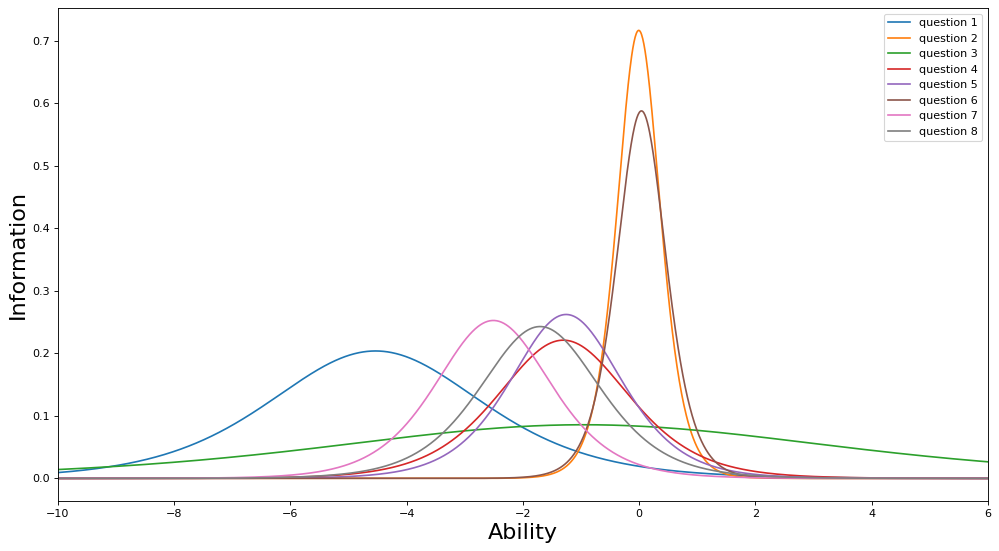

In [59]:
plt.figure(figsize=(15,8), dpi=80)
plt.xlim(right=6)
plt.xlim(left=-10)
for i, y_value in enumerate(y_values_iic):
  plt.plot(test_range, y_value, label=f'question {i+1}')

plt.xlabel("Ability", fontsize="20")
plt.ylabel("Information", fontsize="20")
plt.legend()
plt.show()